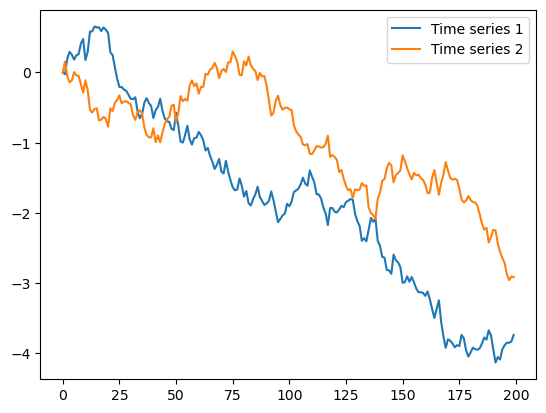

In [1]:
import numpy as np

# Define the parameters
mu = np.array([-1, -2])
sigma = np.array([[1, -0.5], [-0.5, 1]])

# Define the time step and the number of steps
dt = 0.01
n_steps = 200

# Initialize the time series
x = np.zeros((n_steps, 2))

# Simulate the Brownian motion
np.random.seed(0)
dw = np.random.normal(0, np.sqrt(dt), (n_steps, 2))

# Discretize the SDE and simulate the time series
for i in range(1, n_steps):
    x[i] = x[i-1] + mu * dt + np.dot(sigma, dw[i])

# Plot the time series
import matplotlib.pyplot as plt
plt.plot(x[:, 0], label='Time series 1')
plt.plot(x[:, 1], label='Time series 2')
plt.legend()
plt.show()

In [2]:
x1, x2 = x[:, 0], x[:, 1]

dx1 = np.diff(x1)
dx2 = np.diff(x2)

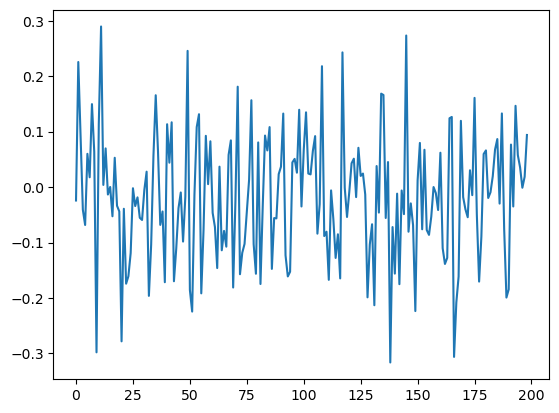

In [3]:
plt.plot(dx1)

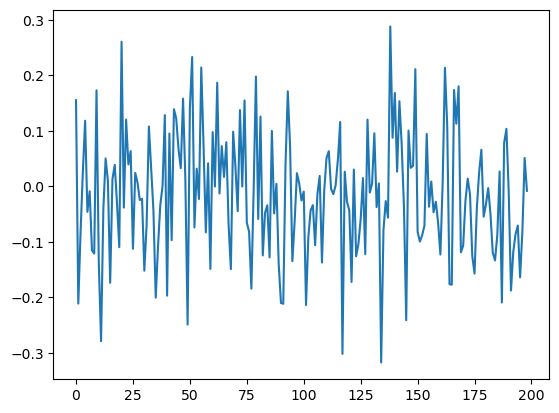

In [4]:
plt.plot(dx2)

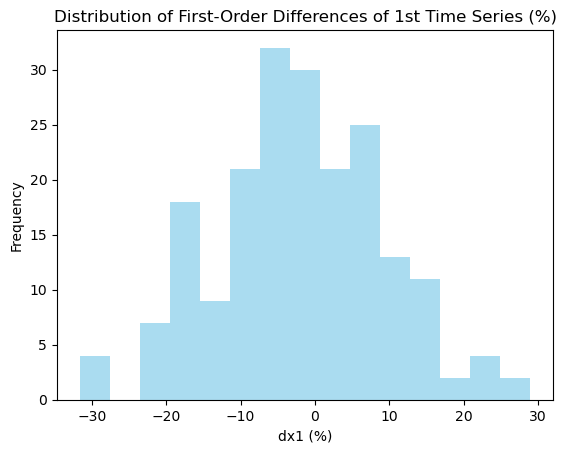

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Multiply data by 100 to calculate percentage
x_pct1 = dx1 * 100


# Create histogram of first-order differences
plt.hist(x_pct1, bins=15, density=False, alpha=0.7, color='skyblue')


# Add labels and title
plt.xlabel('dx1 (%)')
plt.ylabel('Frequency')
plt.title('Distribution of First-Order Differences of 1st Time Series (%)')

plt.show()

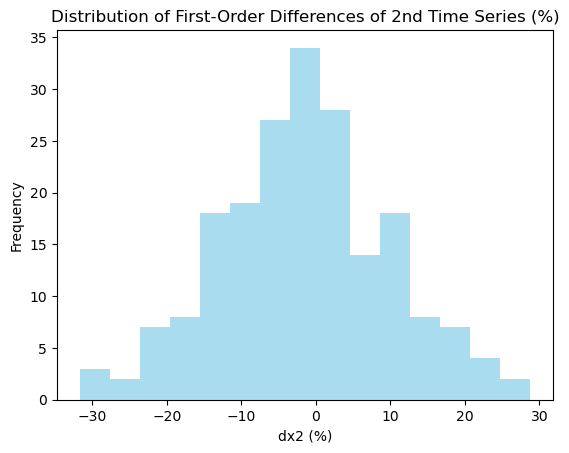

In [6]:
# Multiply data by 100 to calculate percentage
x_pct2 = dx2 * 100


# Create histogram of first-order differences
plt.hist(x_pct2, bins=15, density=False, alpha=0.7, color='skyblue')


# Add labels and title
plt.xlabel('dx2 (%)')
plt.ylabel('Frequency')
plt.title('Distribution of First-Order Differences of 2nd Time Series (%)')

plt.show()

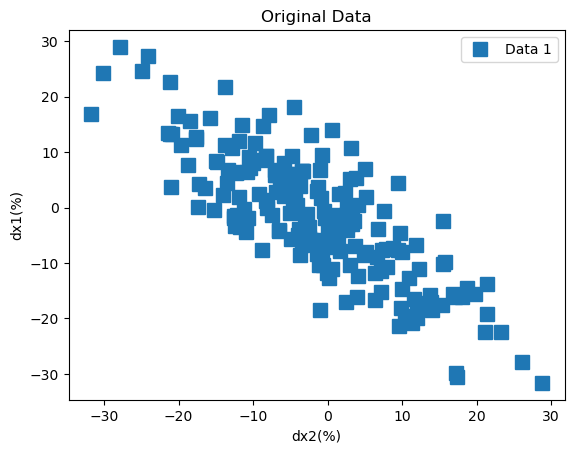

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Plot data with square markers
plt.plot(x_pct2, x_pct1, marker='s', linestyle='None', markersize=10, label='Data 1')

# Add labels and title
plt.xlabel('dx2(%)')
plt.ylabel('dx1(%)')
plt.title('Original Data')
plt.legend()

plt.show()

In [8]:
import numpy as np
from tslearn.piecewise import SymbolicAggregateApproximation



# Parameters for SAX
# - n_bins: Number of symbols to use in the alphabet (e.g., 5)
# - n_segments: Number of segments (e.g., 8)
n_bins = 2

# Initialize the SAX transformer
sax = SymbolicAggregateApproximation(n_segments=199, alphabet_size_avg=2)

array_2d = np.vstack((dx1, dx2))


sax_representation = sax.fit_transform(array_2d)


C:\Users\aarya\.conda\envs\qiskit\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn(


In [9]:
sax_2d = np.array([np.array(xi).flatten() for xi in sax_representation])

In [10]:
import numpy as np

def classical_transition_matrix(transitions):
    n = 2 #number of states
    # Initialize n x n dictionary of 0s
    M = [[0] * n for _ in range(n)]
    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1
    # Convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M
T = [1,4,10,30,50]
transition_matrix_data1 = []
i = 0
for k,l in zip(T,T[1:]):
    arr1 = []
    arr1 = sax_2d[0][k:l]
    transition_matrix_data1.append(classical_transition_matrix(arr1))
    print(f"Transition Matrix for time step {k}:\n{transition_matrix_data1[i]}")
    i = i+1

arr1 = sax_2d[0][T[-1]:]
transition_matrix_data1.append(classical_transition_matrix(arr1))
print(f"Transition Matrix for time step {T[-1]}:\n{transition_matrix_data1[-1]}")
transition_matrix_data1_clip = np.clip(transition_matrix_data1,1e-10,1)

Transition Matrix for time step 1:
[[0, 0], [0.5, 0.5]]
Transition Matrix for time step 4:
[[0.0, 1.0], [0.25, 0.75]]
Transition Matrix for time step 10:
[[0.8461538461538461, 0.15384615384615385], [0.5, 0.5]]
Transition Matrix for time step 30:
[[0.6666666666666666, 0.3333333333333333], [0.42857142857142855, 0.5714285714285714]]
Transition Matrix for time step 50:
[[0.6206896551724138, 0.3793103448275862], [0.5245901639344263, 0.47540983606557374]]


In [11]:
transition_matrix_data2 = []
i = 0
for k,l in zip(T,T[1:]):
    arr1 = []
    arr1 = sax_2d[1][k:l]
    transition_matrix_data2.append(classical_transition_matrix(arr1))
    print(f"Transition Matrix for time step {k}:\n{transition_matrix_data2[i]}")
    i = i+1
arr1 = sax_2d[1][T[-1]:]
transition_matrix_data2.append(classical_transition_matrix(arr1))
print(f"Transition Matrix for time step {T[-1]}:\n{transition_matrix_data2[-1]}")
transition_matrix_data2_clip = np.clip(transition_matrix_data2,1e-10,1)

Transition Matrix for time step 1:
[[0.5, 0.5], [0, 0]]
Transition Matrix for time step 4:
[[0.75, 0.25], [1.0, 0.0]]
Transition Matrix for time step 10:
[[0.4444444444444444, 0.5555555555555556], [0.5, 0.5]]
Transition Matrix for time step 30:
[[0.5, 0.5], [0.36363636363636365, 0.6363636363636364]]
Transition Matrix for time step 50:
[[0.5930232558139535, 0.4069767441860465], [0.5806451612903226, 0.41935483870967744]]


In [12]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace, Operator, DensityMatrix
from qiskit.compiler import transpile, assemble
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Gray code and partition functions
def gray_code(n):
    if n == 0:
        return ['']
    first_half = gray_code(n - 1)
    second_half = first_half[::-1]
    return ['0' + code for code in first_half] + ['1' + code for code in second_half]

def get_partitions_and_reordered_indices(n):
    gray_codes = gray_code(n)
    reordered_indices = [int(code, 2) for code in gray_codes[1:]]
    partitions = {}
    for index in reordered_indices:
        msb = index.bit_length() - 1
        if msb not in partitions:
            partitions[msb] = []
        partitions[msb].append(index)
    return partitions, reordered_indices

In [13]:
sys_qubits= 2
env_qubits = 3
total_qubits = 5
w_layers = 2
h_layers = 2

partitions, reordered_indices = get_partitions_and_reordered_indices(total_qubits)
print('partitions :',partitions)
print('reordered_indices :',reordered_indices)

partitions : {0: [1], 1: [3, 2], 2: [6, 7, 5, 4], 3: [12, 13, 15, 14, 10, 11, 9, 8], 4: [24, 25, 27, 26, 30, 31, 29, 28, 20, 21, 23, 22, 18, 19, 17, 16]}
reordered_indices : [1, 3, 2, 6, 7, 5, 4, 12, 13, 15, 14, 10, 11, 9, 8, 24, 25, 27, 26, 30, 31, 29, 28, 20, 21, 23, 22, 18, 19, 17, 16]


In [14]:
# code for W
def W(qc, alpha, total_qubits, w_layers, inverse=False):
    idx = 0
    for layer in range(w_layers):
        for qubit in range(total_qubits):
            qc.rx(alpha[qubit+idx], qubit)
            idx = idx +1
            qc.ry(alpha[qubit+idx], qubit)
            idx = idx +1
            qc.rz(alpha[qubit+idx], qubit)
        for qubit in range(total_qubits):
            qc.cx(qubit, (qubit + layer + 1)%total_qubits)
        idx = 3*total_qubits*(layer+1)
    if inverse:
            qc = qc.inverse()
    return qc

In [15]:
# code for D
def D(qc,partitions, parameters, reordered_indices, total_qubits, h_layers):
    count = 0
    n = total_qubits
    N = 2**n
    lidx = 0
    for h in range(h_layers):
        for i in range(n):
            # Apply CNOT at the starting
            if count > 0:
                b = 2**i - 1
                xor = partitions[i][0] ^ partitions[i][b]
                l = int(np.log2(xor))
                qc.cx(l, i)
            for j in partitions[i]:
                # Apply the Rz gate
                qc.rz(-2*parameters[j-1+lidx], i)
                # Apply the CNOT gates in between
                if 0 < count < N - 2:
                    if j != 2**i:   
                        xor = reordered_indices[count] ^ reordered_indices[count + 1]
                        l = int(np.log(xor))
                        qc.cx(l, i)
                count += 1
        lidx = N-1+lidx
        count = 0
    return qc

In [16]:
def V(qc,param, total_qubits, W_layers,partitions, reordered_indices, h_layers):
    p = 3*total_qubits*W_layers
    W(qc, param[:p], total_qubits, W_layers, inverse=False)
    D(qc,partitions, param[p:], reordered_indices, total_qubits,h_layers)
    W(qc, param[:p], total_qubits, W_layers, inverse=True)
    return qc
    
p = 3*total_qubits*w_layers

In [17]:
param = [Parameter(f'theta{i}') for i in range(3*w_layers*total_qubits+((2**total_qubits)-1)*h_layers)]

In [18]:
qc = QuantumCircuit(total_qubits)
qc = V(qc,param, total_qubits, w_layers,partitions, reordered_indices, h_layers) 
# qc.draw(output = 'mpl')

In [19]:
np.random.seed(42)
initial_param = [np.random.uniform(0, 4 * np.pi) for i in param]


In [20]:
initial_state = []
initial_state.append(DensityMatrix.from_label('00000').data)
initial_state.append(DensityMatrix.from_label('10000').data)
initial_state.append(DensityMatrix.from_label('00000').data)
initial_state.append(DensityMatrix.from_label('01000').data)
projected_state = []
projected_state.append(DensityMatrix.from_label('0').data)
projected_state.append(DensityMatrix.from_label('1').data)

In [21]:
# , qc, param, initial_state, projected_state, T, p, transition_matrix_data1_clip, transition_matrix_data2_clip
def loss(parameters):
    parameters_array = np.array(parameters)
    prob1 = []
    prob2 = []
    for t in T:
        param_val = parameters_array
        param_val[p:] = param_val[p:]*t
        dictionary = dict(zip(param,param_val))
        bc = qc.assign_parameters(dictionary)
        matrix = Operator(bc).data
        matrix_inv = Operator(bc.inverse()).data
        state = []
        for i in initial_state:
            state.append(matrix@i@matrix_inv)
        state[0] = partial_trace(state[0],[1,2,3,4])
        state[1] = partial_trace(state[1],[1,2,3,4])
        state[2] = partial_trace(state[2],[0,2,3,4])
        state[3] = partial_trace(state[3],[0,2,3,4])
        prob1.append([[np.real(np.trace(state[i]@projected_state[j]))for j in range(2)]for i in range(2)])
        prob2.append([[np.real(np.trace(state[i+2]@projected_state[j]))for j in range(2)]for i in range(2)])

    prob1_clip = np.clip(prob1, 1e-10, 1)
    prob2_clip = np.clip(prob2, 1e-10, 1)

    loss = 0
    for i in range(5):
        for j in range(2):
            for k in range(2):
                loss = loss + prob1_clip[i][j][k]*np.log(prob1_clip[i][j][k]/transition_matrix_data1_clip[i][j][k])
                loss = loss + prob2_clip[i][j][k]*np.log(prob2_clip[i][j][k]/transition_matrix_data2_clip[i][j][k])
    return loss  

In [22]:
def Prob(parameters):
    parameters_array = np.array(parameters)
    prob1 = []
    prob2 = []
    for t in T:
        param_val = parameters_array
        param_val[p:] = param_val[p:]*t
        dictionary = dict(zip(param,param_val))
        bc = qc.assign_parameters(dictionary)
        matrix = Operator(bc).data
        matrix_inv = Operator(bc.inverse()).data
        state = []
        for i in initial_state:
            state.append(matrix@i@matrix_inv)
        state[0] = partial_trace(state[0],[1,2,3,4])
        state[1] = partial_trace(state[1],[1,2,3,4])
        state[2] = partial_trace(state[2],[0,2,3,4])
        state[3] = partial_trace(state[3],[0,2,3,4])
        prob1.append([[np.real(np.trace(state[i]@projected_state[j]))for j in range(2)]for i in range(2)])
        prob2.append([[np.real(np.trace(state[i+2]@projected_state[j]))for j in range(2)]for i in range(2)])
    return prob1, prob2

In [23]:
import numpy as np
from scipy.optimize import minimize


# Define the bounds for each parameter
bounds = [(None, None) for _ in range(92)]

# Define the initial guess for the parameters
initial_guess = initial_param

# Define the block size (30 parameters at a time)
block_size = 30

# Define the number of blocks
num_blocks = int(np.ceil(92 / block_size))

# Optimize each block of parameters
for iteration in range(6):  # Repeat the optimization process 10 times
    for i in range(num_blocks):
        block_start = i * block_size
        block_end = min((i + 1) * block_size, 92)
        block_initial_guess = initial_guess[block_start:block_end]
        
        def block_objective_function(block_params):
            initial_guess[block_start:block_end] = block_params
            return loss(initial_guess)
        
        res = minimize(block_objective_function, block_initial_guess, method="COBYLA", bounds=None)
        initial_guess[block_start:block_end] = res.x
        
        # Print some logging information
        print(f"Iteration {iteration}, Block {i}: {res.fun:.4f}")

# Print the optimized parameters
print(initial_guess)

# Print the minimum value of the objective function
print(loss(initial_guess))

Iteration 0, Block 0: 48.5549
Iteration 0, Block 1: 48.2918
Iteration 0, Block 2: 48.2670
Iteration 0, Block 3: 48.3614
Iteration 1, Block 0: 47.2357
Iteration 1, Block 1: 47.2229
Iteration 1, Block 2: 47.2154
Iteration 1, Block 3: 47.2359
Iteration 2, Block 0: 47.1685
Iteration 2, Block 1: 47.1971
Iteration 2, Block 2: 47.2398
Iteration 2, Block 3: 47.2413
Iteration 3, Block 0: 47.1793
Iteration 3, Block 1: 47.2256
Iteration 3, Block 2: 46.9729
Iteration 3, Block 3: 47.0588
Iteration 4, Block 0: 46.8897
Iteration 4, Block 1: 46.9938
Iteration 4, Block 2: 46.9503
Iteration 4, Block 3: 47.0342
Iteration 5, Block 0: 46.7488
Iteration 5, Block 1: 46.7246
Iteration 5, Block 2: 46.6241
Iteration 5, Block 3: 46.6352
[5.542634726565363, 13.101180207275057, 9.66523285823383, 8.333542049088269, 3.728746174316914, 2.4191648217929655, 0.13124491566193205, 11.500429441564938, 7.253528822805088, 8.1746014484915, 1.3795112906563662, 11.713009324888779, 12.051893519577431, 4.168204772592591, 1.067245

In [24]:
opt_param = initial_guess

In [25]:
prob1, prob2 = Prob(opt_param)
print(prob1)
print()
print(prob2)

[[[0.3519185497664627, 0.6480814502335381], [0.4084555707166987, 0.5915444292833021]], [[0.03334319270362652, 0.9666568072963738], [0.5302430840641019, 0.46975691593589824]], [[0.6643515264758717, 0.3356484735241291], [0.5167134483509945, 0.483286551649006]], [[0.4834396028921343, 0.5165603971078656], [0.4404324589549433, 0.5595675410450569]], [[0.5710624443877602, 0.428937555612239], [0.6305720784822261, 0.36942792151777315]]]

[[[0.5707423821957739, 0.42925761780422694], [0.4074214600764612, 0.5925785399235397]], [[0.5820602926018787, 0.4179397073981216], [0.9584095372134358, 0.04159046278656424]], [[0.49230101229605955, 0.5076989877039411], [0.4998618220353024, 0.5001381779646985]], [[0.5022176044172579, 0.49778239558274184], [0.41549985999734196, 0.5845001400026582]], [[0.5238299122922581, 0.47617008770774116], [0.5187609827727415, 0.48123901722725754]]]


In [33]:
simulator = AerSimulator()
array = []
for t in range(199):
    param_val = np.array(opt_param)
    param_val[p:] = param_val[p:]*t
    dictionary = dict(zip(param,param_val))
    bc = qc.assign_parameters(dictionary)
    bc.measure_all()
    compiled_circuit = transpile(bc, simulator)
    result = simulator.run(compiled_circuit, shots=1).result()
    counts = result.get_counts(bc)
    full_measurement = list(counts.keys())[0]
    measured_array = [int(bit) for bit in full_measurement[:2]]
    array.append(measured_array)

In [34]:
gx1= [a[0] for a in array]
gx2= [a[1] for a in array]
gen_data = np.vstack((gx1, gx2))

In [35]:
q_data = np.reshape(gen_data,(2,199,1))
time_series_inverse = sax.inverse_transform(q_data)

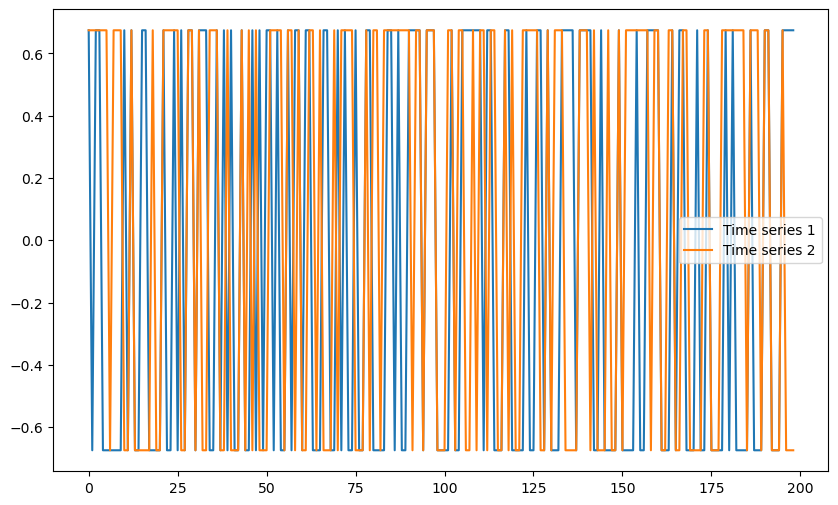

In [36]:
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(time_series_inverse[i], label=f"Time series {i+1}")
plt.legend()
plt.show()

In [37]:
q_gen_data1 = np.cumsum(time_series_inverse[0]) + [0]
q_gen_data2 = np.cumsum(time_series_inverse[1]) + [0]

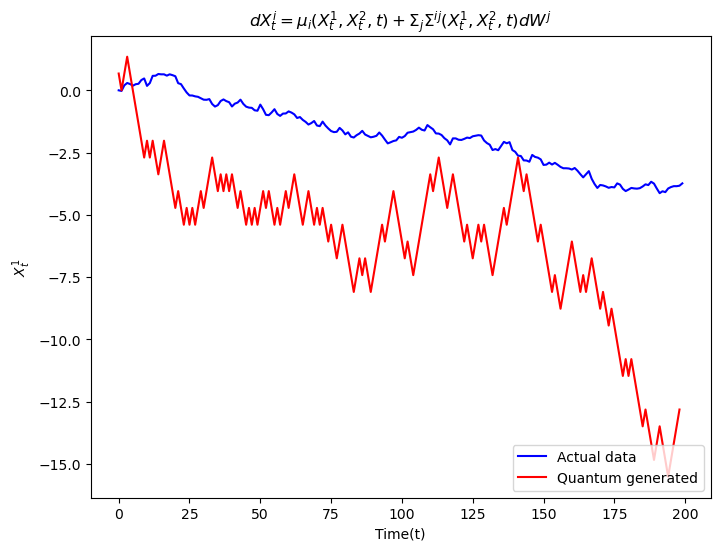

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = x1
data2 = q_gen_data1

# Plotting the data
plt.figure(figsize=(8, 6))  # Create a new figure with a specified size

# Plot the first dataset
plt.plot(data1, label='Actual data', color='blue')

# Plot the second dataset
plt.plot(data2, label='Quantum generated', color='red')

# Add labels and title
plt.xlabel('Time(t)')
plt.ylabel(r'$X_t^1$')
equation = r'$dX_t^i = \mu_i(X_t^1, X_t^2, t) + \Sigma_j\Sigma^{ij}(X_t^1, X_t^2, t)dW^j$'
plt.title(equation)

# Add a legend to differentiate the datasets
plt.legend(loc='lower right')
plt.savefig('data1', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


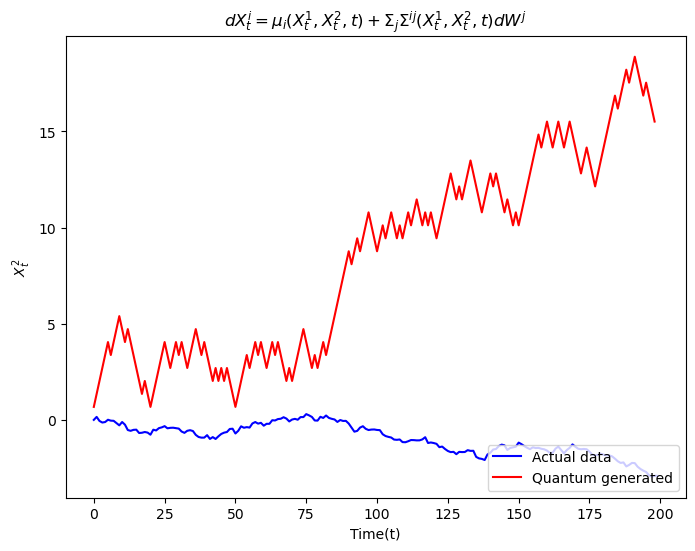

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = x2
data2 = q_gen_data2

# Plotting the data
plt.figure(figsize=(8, 6))  # Create a new figure with a specified size

# Plot the first dataset
plt.plot(data1, label='Actual data', color='blue')

# Plot the second dataset
plt.plot(data2, label='Quantum generated', color='red')

# Add labels and title
plt.xlabel('Time(t)')
plt.ylabel(r'$X_t^2$')
equation = r'$dX_t^i = \mu_i(X_t^1, X_t^2, t) + \Sigma_j\Sigma^{ij}(X_t^1, X_t^2, t)dW^j$'
plt.title(equation)

# Add a legend to differentiate the datasets
plt.legend(loc='lower right')
plt.savefig('data2', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
